In [1]:
# imports
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = np.load('/kaggle/input/channelflow/channel_flow.npy')

In [3]:
phi_tot = tf.expand_dims(data, axis=3)
new_phi = phi_tot[:490]
print(np.shape(new_phi))
phi_test = phi_tot[490:]

(490, 511, 127, 1)


In [4]:

# NN

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.01,
  decay_steps=500,
  decay_rate=0.5,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Nadam()


def compile_and_fit(model, name, optimizer=None, max_epochs=10000):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanSquaredError() ,
                metrics=[tf.keras.losses.MeanAbsoluteError()]),
                

    model.summary()

    history = model.fit(
            new_phi, new_phi,
            #steps_per_epoch = STEPS_PER_EPOCH,
            epochs=500,
            validation_split=0.1,
            callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=20),
            verbose=2)

    return history



In [5]:

y = tf.keras.layers.AveragePooling2D(pool_size=(3, 3),
   padding='valid')(new_phi)
#y = tf.keras.layers.Conv2D(2, 3, padding= 'valid',activation='linear', input_shape=(127,127,))(new_phi)
print(tf.shape(y))

tf.Tensor([490 170  42   1], shape=(4,), dtype=int32)


In [6]:


NN1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu', input_shape=(256,64,)),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Reshape((256, 64, 1)),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Cropping2D(((1, 0), (1, 0)))
])
NN2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(128, 3),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(1, 5),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Cropping2D(((1, 0), (1, 0)))
])
# inputs      = tf.keras.Input(shape=(3,))
# outputs     = dense(inputs)
# Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

inputs      = tf.keras.Input(shape=(new_phi.shape[1:]))
#outputs     = inputs[:,0:3] + 0.01*dense(inputs)
#upscaling davanti a NN1
outputs     = NN1(tf.keras.layers.AveragePooling2D(pool_size=(2, 2),padding='same')(inputs)) + NN2(inputs)
Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

history = compile_and_fit(Updatemodel, 'Lorentz')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 511, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 average_pooling2d_1 (AveragePo  (None, 256, 64, 1)  0           ['input_1[0][0]']                
 oling2D)                                                                                         
                                                                                                  
 sequential (Sequential)        (None, 511, 127, 1)  2400        ['average_pooling2d_1[0][0]']    
                                                                                              

In [7]:
test_true = phi_test
test_model = history.model.predict(phi_test)

1/1 [==============================] - 0s 484ms/step


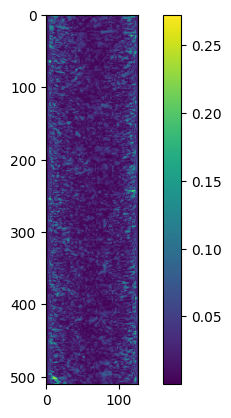

In [8]:
plt.imshow(np.abs(test_true[-1]-test_model[-1]))
plt.colorbar()

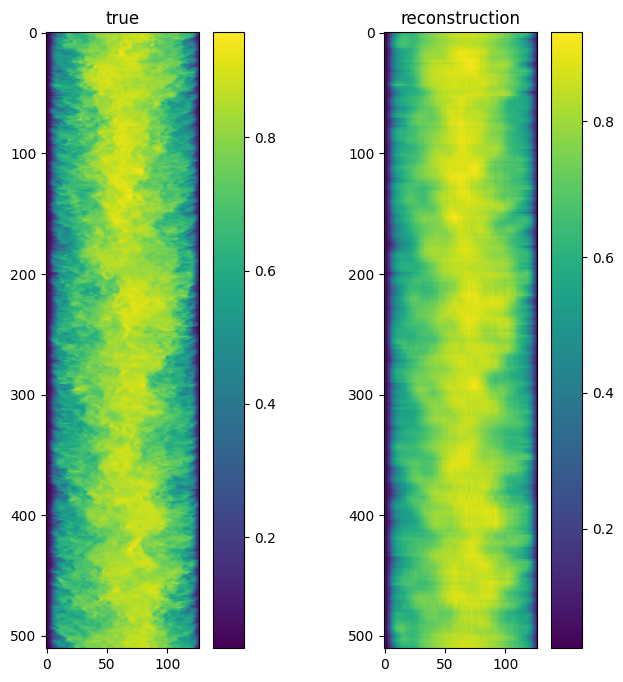

In [9]:
ind = -1
fig,axs = plt.subplots(1,2,figsize=(8,8))
im = axs[0].imshow(test_true[ind])
axs[0].set_title('true')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(test_model[ind])
axs[1].set_title('reconstruction')
plt.colorbar(im, ax=axs[1])

In [10]:
print(test_model[-1])

[[[0.0373702 ]
  [0.04001985]
  [0.04001985]
  ...
  [0.24694504]
  [0.09761591]
  [0.09761591]]

 [[0.03362943]
  [0.04185072]
  [0.04185072]
  ...
  [0.26736075]
  [0.10109857]
  [0.10109857]]

 [[0.03362943]
  [0.04185072]
  [0.04185072]
  ...
  [0.26736075]
  [0.10109857]
  [0.10109857]]

 ...

 [[0.02726308]
  [0.03992266]
  [0.03992266]
  ...
  [0.24246018]
  [0.09312383]
  [0.09312383]]

 [[0.02727291]
  [0.03843557]
  [0.03843557]
  ...
  [0.24624705]
  [0.09417897]
  [0.09417897]]

 [[0.02727291]
  [0.03843557]
  [0.03843557]
  ...
  [0.24624705]
  [0.09417897]
  [0.09417897]]]
